In [2]:
from pathlib import Path
import tiktoken
from tiktoken.load import load_tiktoken_bpe
import torch
import json
import matplotlib.pyplot as plt

In [3]:
files = Path('Chapter8/llama/Meta-Llama-3-8B').glob('*')
files = list(files)
print(files)

[PosixPath('Chapter8/llama/Meta-Llama-3-8B/checklist.chk'), PosixPath('Chapter8/llama/Meta-Llama-3-8B/consolidated.00.pth'), PosixPath('Chapter8/llama/Meta-Llama-3-8B/params.json'), PosixPath('Chapter8/llama/Meta-Llama-3-8B/tokenizer.model')]


In [4]:
tokenizer_path = "Chapter8/llama/Meta-Llama-3-8B/tokenizer.model"
special_tokens = [
            "<|begin_of_text|>",
            "<|end_of_text|>",
            "<|reserved_special_token_0|>",
            "<|reserved_special_token_1|>",
            "<|reserved_special_token_2|>",
            "<|reserved_special_token_3|>",
            "<|start_header_id|>",
            "<|end_header_id|>",
            "<|reserved_special_token_4|>",
            "<|eot_id|>",  # end of turn
        ] + [f"<|reserved_special_token_{i}|>" for i in range(5, 256 - 5)]
mergeable_ranks = load_tiktoken_bpe(tokenizer_path)
tokenizer = tiktoken.Encoding(
    name=Path(tokenizer_path).name,
    pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",
    mergeable_ranks=mergeable_ranks,
    special_tokens={token: len(mergeable_ranks) + i for i, token in enumerate(special_tokens)},
)

tokenizer.decode(tokenizer.encode("Hello, world!"))

'Hello, world!'

In [5]:
model = torch.load("Chapter8/llama/Meta-Llama-3-8B/consolidated.00.pth")

In [6]:
print(json.dumps(list(model.keys()), indent=4))

[
    "tok_embeddings.weight",
    "layers.0.attention.wq.weight",
    "layers.0.attention.wk.weight",
    "layers.0.attention.wv.weight",
    "layers.0.attention.wo.weight",
    "layers.0.feed_forward.w1.weight",
    "layers.0.feed_forward.w3.weight",
    "layers.0.feed_forward.w2.weight",
    "layers.0.attention_norm.weight",
    "layers.0.ffn_norm.weight",
    "layers.1.attention.wq.weight",
    "layers.1.attention.wk.weight",
    "layers.1.attention.wv.weight",
    "layers.1.attention.wo.weight",
    "layers.1.feed_forward.w1.weight",
    "layers.1.feed_forward.w3.weight",
    "layers.1.feed_forward.w2.weight",
    "layers.1.attention_norm.weight",
    "layers.1.ffn_norm.weight",
    "layers.2.attention.wq.weight",
    "layers.2.attention.wk.weight",
    "layers.2.attention.wv.weight",
    "layers.2.attention.wo.weight",
    "layers.2.feed_forward.w1.weight",
    "layers.2.feed_forward.w3.weight",
    "layers.2.feed_forward.w2.weight",
    "layers.2.attention_norm.weight",
    "lay

In [7]:
with open("Chapter8/llama/Meta-Llama-3-8B/params.json", 'r') as f:
    config = json.load(f)
config

{'dim': 4096,
 'n_layers': 32,
 'n_heads': 32,
 'n_kv_heads': 8,
 'vocab_size': 128256,
 'multiple_of': 1024,
 'ffn_dim_multiplier': 1.3,
 'norm_eps': 1e-05,
 'rope_theta': 500000.0}

# Text to Tokens

In [8]:
dim = config['dim']
n_layers = config['n_layers']
n_heads = config['n_heads']
n_kv_heads = config["n_kv_heads"]
vocab_size = config["vocab_size"]
multiple_of = config["multiple_of"]
ffn_dim_multiplier = config["ffn_dim_multiplier"]
norm_eps = config["norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])

In [11]:
prompt = "The answer to the ultimate question of life, the universe, and everything is "
tokens = [128000] + tokenizer.encode(prompt)
print(tokens)
tokens = torch.tensor(tokens)
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
print(prompt_split_as_tokens)

[128000, 791, 4320, 311, 279, 17139, 3488, 315, 2324, 11, 279, 15861, 11, 323, 4395, 374, 220]
['<|begin_of_text|>', 'The', ' answer', ' to', ' the', ' ultimate', ' question', ' of', ' life', ',', ' the', ' universe', ',', ' and', ' everything', ' is', ' ']


In [14]:
len(tokens)

17

# Tokens to their embedding 

In [12]:
embedding_layer = torch.nn.Embedding(vocab_size, dim)
embedding_layer.weight.data.copy_(model["tok_embeddings.weight"])
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)
token_embeddings_unnormalized.shape

torch.Size([17, 4096])

In [15]:
token_embeddings_unnormalized[0]

tensor([-1.4305e-04,  1.0777e-04, -1.9646e-04,  ...,  2.0218e-04,
         1.4842e-05,  3.0136e-04], dtype=torch.bfloat16,
       grad_fn=<SelectBackward0>)

## Normalize the embedding

$$ \bar{a}_i = \frac{a_i}{\text{RMS}(\mathbf{a})}g_i, \quad \text{where} \quad \text{RMS}(\mathbf{a}) = \sqrt{\frac{1}{n} \sum_{i=1}^{n} a_i^2} $$

- `tensor` or $a$ is the original input
- `norm_weights` or $g_i$ is a learnable parameter, it's multiplied with the normalized value to scale them 
Eqation steps:
1. compute the square of each element in the tensor
2. compute the mean of the squared values along the last dimenstition
3. Computes the reciprocal of the square root (equivalent to $ \frac{1} {\sqrt{}} $ ) + `norm_eps` (a small epsilon value) prevents division by zero
4. `tensor` * ...: This scales the tensor elements by the reciprocal RMS


In [17]:
def rms_norm(tensor, norm_weights):
    return (tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps)) * norm_weights

# Bulding the transformers blocks
![image.png](llama-architectur.png)

### Bulding the first layer: Normalization 

In [20]:
token_embeddings = rms_norm(token_embeddings_unnormalized, model["layers.0.attention_norm.weight"])

In [22]:
print(token_embeddings[0])
token_embeddings.shape

tensor([-9.8419e-04,  2.8839e-03, -1.1292e-02,  ...,  2.2278e-03,
         8.2970e-05,  1.1292e-03], dtype=torch.bfloat16,
       grad_fn=<SelectBackward0>)


torch.Size([17, 4096])

### Attention implementation

In [23]:
print(
    model["layers.0.attention.wq.weight"].shape, # query
    model["layers.0.attention.wk.weight"].shape, # key
    model["layers.0.attention.wv.weight"].shape, # value
    model["layers.0.attention.wo.weight"].shape # output
)

torch.Size([4096, 4096]) torch.Size([1024, 4096]) torch.Size([1024, 4096]) torch.Size([4096, 4096])


- the authors bundled the weights of the heads togeather because its helps parallize attention head multipliastion

#### unwrapping query
- after unwrap the queries from multiple attention heads, the resulting shape is [32x128x4096]
- 32 attention heads
- 128 size of the query vector
- 4096 is the size of the token embedding

In [24]:
q_layer0 = model['layers.0.attention.wq.weight']
head_dim = q_layer0.shape[0] // n_heads
q_layer0 = q_layer0.view(n_heads, head_dim, dim)
q_layer0.shape

torch.Size([32, 128, 4096])

#### Implenting the first head of the first layer

In [26]:
q_layer0_head0 = q_layer0[0]
q_layer0_head0.shape

torch.Size([128, 4096])

multiply the query weights with the token embedding to recive a query for the token
- for each token there is a 128 length query

In [27]:
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)
q_per_token.shape

torch.Size([17, 128])

In [41]:
# the query for " the" token
q_per_token[4][0]

tensor(0.4980, dtype=torch.bfloat16, grad_fn=<SelectBackward0>)

In [42]:
# the query for another " the" token
q_per_token[10][0]

tensor(0.4980, dtype=torch.bfloat16, grad_fn=<SelectBackward0>)

- The indivitually query vector gas no idea about the postion in the prompt
- we want each a query vector to have a different vectors

### Implementing Rortory Positional Embedding (RoPE)
$f_{\{q,k\}}(x_m, m) = 
\begin{pmatrix}
\cos m \theta & -\sin m \theta \\
\sin m \theta & \cos m \theta
\end{pmatrix}
\begin{pmatrix}
W^{(11)}_{\{q,k\}} & W^{(12)}_{\{q,k\}} \\
W^{(21)}_{\{q,k\}} & W^{(22)}_{\{q,k\}}
\end{pmatrix}
\begin{pmatrix}
x_m^{(1)} \\
x_m^{(2)}
\end{pmatrix}
$

- The first part is the most importent part, it rotate the vector by angle of $m \theta$ where $m$ is the absolute position of the tokken in a sentense
- We apply the rottent only on the query and the key

This is how we gonna implement it

$
R_{\Theta, m}^d x = 
\begin{pmatrix}
x_1 \\
x_2 \\
x_3 \\
x_4 \\
\vdots \\
x_{d-1} \\
x_d
\end{pmatrix}
\otimes
\begin{pmatrix}
\cos m \theta_1 \\
\cos m \theta_1 \\
\cos m \theta_2 \\
\cos m \theta_2 \\
\vdots \\
\cos m \theta_{d/2} \\
\cos m \theta_{d/2}
\end{pmatrix}
+
\begin{pmatrix}
-x_2 \\
x_1 \\
-x_4 \\
x_3 \\
\vdots \\
-x_d \\
x_{d-1}
\end{pmatrix}
\otimes
\begin{pmatrix}
\sin m \theta_1 \\
\sin m \theta_1 \\
\sin m \theta_2 \\
\sin m \theta_2 \\
\vdots \\
\sin m \theta_{d/2} \\
\sin m \theta_{d/2}
\end{pmatrix}
$


In [54]:
q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
q_per_token_split_into_pairs.shape

torch.Size([17, 64, 2])

In [47]:
zero_to_one_split_into_64_parts = torch.tensor(range(64))/64
zero_to_one_split_into_64_parts

tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])

In [48]:
freqs = 1.0 / (rope_theta ** zero_to_one_split_into_64_parts)
freqs

tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01,
        2.9223e-01, 2.3805e-01, 1.9392e-01, 1.5797e-01, 1.2869e-01, 1.0483e-01,
        8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03,
        7.2927e-03, 5.9407e-03, 4.8394e-03, 3.9423e-03, 3.2114e-03, 2.6161e-03,
        2.1311e-03, 1.7360e-03, 1.4142e-03, 1.1520e-03, 9.3847e-04, 7.6450e-04,
        6.2277e-04, 5.0732e-04, 4.1327e-04, 3.3666e-04, 2.7425e-04, 2.2341e-04,
        1.8199e-04, 1.4825e-04, 1.2077e-04, 9.8381e-05, 8.0143e-05, 6.5286e-05,
        5.3183e-05, 4.3324e-05, 3.5292e-05, 2.8750e-05, 2.3420e-05, 1.9078e-05,
        1.5542e-05, 1.2660e-05, 1.0313e-05, 8.4015e-06, 6.8440e-06, 5.5752e-06,
        4.5417e-06, 3.6997e-06, 3.0139e-06, 2.4551e-06])

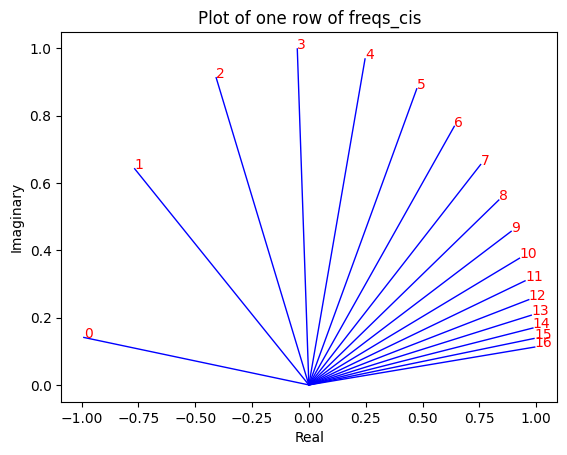

In [49]:
freqs_for_each_token = torch.outer(torch.arange(17), freqs)
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)
freqs_cis.shape


value = freqs_cis[3]
plt.figure()
for i, element in enumerate(value[:17]):
    plt.plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {i}")
    plt.annotate(f"{i}", xy=(element.real, element.imag), color='red')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Plot of one row of freqs_cis')
plt.show()

- now we rotate the query based on the position
1. conver it to complex numbers
2. then dot product

In [55]:
q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
q_per_token_as_complex_numbers.shape

torch.Size([17, 64])

In [56]:
q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis
q_per_token_as_complex_numbers_rotated.shape

torch.Size([17, 64])

In [57]:
q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)
q_per_token_split_into_pairs_rotated.shape

torch.Size([17, 64, 2])

now we merged the rotated pairs

In [58]:
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
q_per_token_rotated.shape

torch.Size([17, 128])

## implementing keys 

In [59]:
k_layer0 = model["layers.0.attention.wk.weight"]
k_layer0 = k_layer0.view(n_kv_heads, k_layer0.shape[0] // n_kv_heads, dim)
k_layer0.shape

torch.Size([8, 128, 4096])

In [60]:
k_layer0_head0 = k_layer0[0]
k_layer0_head0.shape

torch.Size([128, 4096])

In [61]:
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T)
k_per_token.shape

torch.Size([17, 128])

In [62]:
k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
k_per_token_split_into_pairs.shape

torch.Size([17, 64, 2])

In [63]:
k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
k_per_token_as_complex_numbers.shape

torch.Size([17, 64])

In [64]:
k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
k_per_token_split_into_pairs_rotated.shape

torch.Size([17, 64, 2])

In [73]:
k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
k_per_token_rotated.shape

torch.Size([17, 128])

## Multiply the queries and key matrices
- Doing this will give us a score mapping each token with one another 
- the score describes how each token's query relates to the each token's key (self attention) 

In [74]:
qk_per_token = torch.matmul(k_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5
qk_per_token.shape

torch.Size([17, 17])

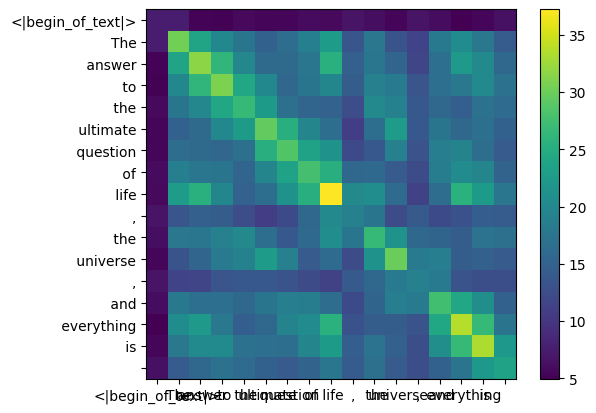

In [69]:
def display_qk_heatmap(qk_per_token):
    _, ax = plt.subplots()
    im = ax.imshow(qk_per_token.to(float).detach(), cmap='viridis')
    ax.set_xticks(range(len(prompt_split_as_tokens)))
    ax.set_yticks(range(len(prompt_split_as_tokens)))
    ax.set_xticklabels(prompt_split_as_tokens)
    ax.set_yticklabels(prompt_split_as_tokens)
    ax.figure.colorbar(im, ax=ax)
    
display_qk_heatmap(qk_per_token)

In [75]:
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
mask = torch.triu(mask, diagonal=1)
mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -in

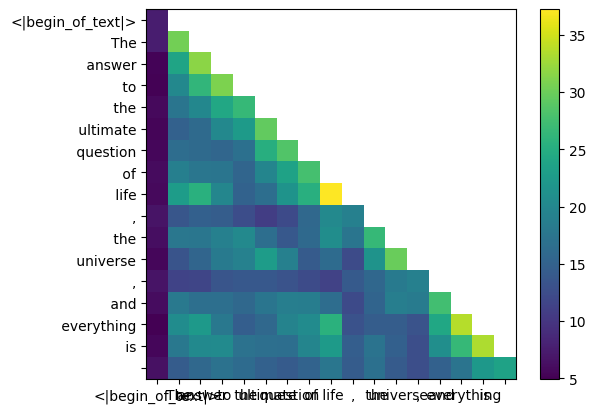

In [76]:
qk_per_token_after_masking = qk_per_token + mask
display_qk_heatmap(qk_per_token_after_masking)

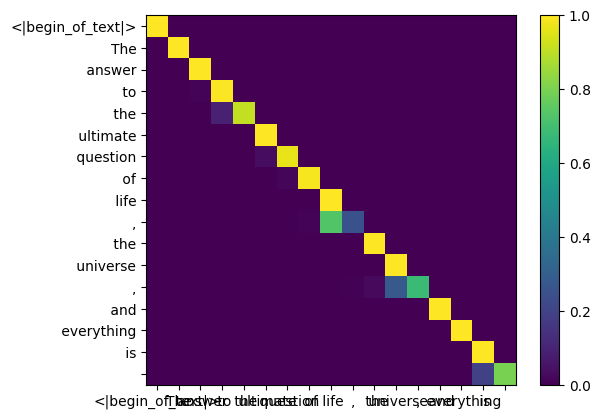

In [77]:
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
display_qk_heatmap(qk_per_token_after_masking_after_softmax)

## Values matrix

In [78]:
v_layer0 = model["layers.0.attention.wv.weight"]
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)
v_layer0.shape

torch.Size([8, 128, 4096])

In [79]:
v_layer0_head0 = v_layer0[0]
v_layer0_head0.shape

torch.Size([128, 4096])

In [80]:
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T)
v_per_token.shape

torch.Size([17, 128])

## Loop to do the same for all the heads in the first layers

In [81]:
qkv_attention_store = []

for head in range(n_heads):
    q_layer0_head = q_layer0[head]
    k_layer0_head = k_layer0[head//4] # key weights are shared across 4 heads
    v_layer0_head = v_layer0[head//4] # value weights are shared across 4 heads
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T)
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T)
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T)

    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
    q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
    q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)

    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
    k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
    k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    mask = torch.triu(mask, diagonal=1)
    qk_per_token_after_masking = qk_per_token + mask
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention_store.append(qkv_attention)

len(qkv_attention_store)

32

now we mearge all attention scores into one large matrix

In [82]:
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
stacked_qkv_attention.shape

torch.Size([17, 4096])

In [83]:
w_layer0 = model["layers.0.attention.wo.weight"]
w_layer0.shape

torch.Size([4096, 4096])

## linear layer

In [84]:
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T)
embedding_delta.shape

torch.Size([17, 4096])

now we add the original token embedding to the modefied embedding attention

In [85]:
embedding_after_edit = token_embeddings_unnormalized + embedding_delta
embedding_after_edit.shape

torch.Size([17, 4096])

normalize and then run a feed forward neural network

In [86]:
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["layers.0.ffn_norm.weight"])
embedding_after_edit_normalized.shape

torch.Size([17, 4096])

#### loading the ff weights and implementing the feed forward network

In [87]:
w1 = model["layers.0.feed_forward.w1.weight"]
w2 = model["layers.0.feed_forward.w2.weight"]
w3 = model["layers.0.feed_forward.w3.weight"]
output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
output_after_feedforward.shape

torch.Size([17, 4096])

In [88]:
layer_0_embedding = embedding_after_edit+output_after_feedforward
layer_0_embedding.shape

torch.Size([17, 4096])

## loop what we did but for the remaning layers

In [89]:
final_embedding = token_embeddings_unnormalized
for layer in range(n_layers):
    qkv_attention_store = []
    layer_embedding_norm = rms_norm(final_embedding, model[f"layers.{layer}.attention_norm.weight"])
    q_layer = model[f"layers.{layer}.attention.wq.weight"]
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)
    k_layer = model[f"layers.{layer}.attention.wk.weight"]
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    v_layer = model[f"layers.{layer}.attention.wv.weight"]
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    for head in range(n_heads):
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head//4]
        v_layer_head = v_layer[head//4]
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis)
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
        mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
        mask = torch.triu(mask, diagonal=1)
        qk_per_token_after_masking = qk_per_token + mask
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
        qkv_attention_store.append(qkv_attention)

    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
    embedding_after_edit = final_embedding + embedding_delta
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"layers.{layer}.ffn_norm.weight"])
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
    final_embedding = embedding_after_edit+output_after_feedforward

In [90]:
final_embedding = rms_norm(final_embedding, model["norm.weight"])
final_embedding.shape

torch.Size([17, 4096])

## Finaly: we decode the embedding to the token value

In [91]:
model["output.weight"].shape

torch.Size([128256, 4096])

In [92]:
logits = torch.matmul(final_embedding[-1], model["output.weight"].T)
logits.shape

torch.Size([128256])

In [93]:
next_token = torch.argmax(logits, dim=-1)
next_token

tensor(2983)

In [94]:
tokenizer.decode([next_token.item()])

'42'